In [38]:
import torch
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pickle 
from transformers import (AutoTokenizer, 
                          AutoModelForCausalLM)

# # Configuration
K = 1.25  # super-linearity parameter
MODEL_NAME = "ai-forever/mGPT"  # Multilingual model
DATA_DIR = Path("data/processed")

# Test mode: set to True to process only 100 pairs per language
TEST_MODE = True  
MAX_PAIRS_TEST = 1417

# Load model and tokenizer
print(f"Loading model: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
model.eval()
print("Model loaded!")
if TEST_MODE:
    print(f"⚠ TEST MODE: Will process only {MAX_PAIRS_TEST} pairs per language")

Loading model: ai-forever/mGPT


Loading weights:   0%|          | 0/293 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie transformer.wte.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
GPT2LMHeadModel LOAD REPORT from: ai-forever/mGPT
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
transformer.h.{0...23}.attn.bias        | UNEXPECTED |  | 
transformer.h.{0...23}.attn.masked_bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Model loaded!
⚠ TEST MODE: Will process only 1417 pairs per language


In [39]:
import seaborn as sns
sns.set(context='paper', 
        style='ticks', 
        font_scale=1.2,)

sns.set_palette('colorblind')

In [40]:
# Load all language pairs
languages = {
    "de": "German",
    "es": "Spanish", 
    "fr": "French",
    "ru": "Russian"
}

all_data = {}
for lang_code, lang_name in languages.items():
    pickle_file = DATA_DIR / f"{lang_code}_sentence_pairs_color_adj.pkl"
    if pickle_file.exists():
        with open(pickle_file, 'rb') as f:
            all_data[lang_code] = pickle.load(f)
        print(f"Loaded {lang_name}: {len(all_data[lang_code])} pairs")
    else:
        print(f"⚠ {lang_name} file not found: {pickle_file}")

print(f"\nTotal languages loaded: {len(all_data)}")

Loaded German: 1417 pairs
Loaded Spanish: 10000 pairs
Loaded French: 5651 pairs
Loaded Russian: 4069 pairs

Total languages loaded: 4


In [41]:
all_data['de'][:3]

[('Der wird deutlich größer und kräftiger und ist gleichmäßig gelb gefärbt, ohne lachsrosa oder orange Töne.',
  'Der wird deutlich größer und kräftiger und ist gleichmäßig gelb gefärbt, ohne lachsrosa oder Töne.',
  'Orange',
  'Ton'),
 ('Bei ihnen überlagert das schwarze Melanin jedoch das Gelb der Kopfmaske.',
  'Bei ihnen überlagert das Melanin jedoch das Gelb der Kopfmaske.',
  'schwarz',
  'Melanin'),
 ('1782 erschien eine Veröffentlichung von Carl Wilhelm Scheele, die die Herstellung von Blausäure sowohl aus gelbem Blutlaugensalz und Schwefelsäure als auch aus Berliner Blau und Schwefelsäure beschreibt.',
  '1782 erschien eine Veröffentlichung von Carl Wilhelm Scheele, die die Herstellung von Blausäure sowohl aus Blutlaugensalz und Schwefelsäure als auch aus Berliner Blau und Schwefelsäure beschreibt.',
  'gelb',
  'Blutlaugensalz')]

In [42]:
def compute_uid_inverse(model, input_ids, k):
    """
    Super-linear UID as in Meister et al. (2021), Eq. 6
    """
    with torch.no_grad():
        logits = model(input_ids).logits

    shifted_logits = logits[:, :-1, :]
    shifted_ids = input_ids[:, 1:]

    log_probs = torch.log_softmax(shifted_logits, dim=-1)
    token_log_probs = log_probs.gather(
        2, shifted_ids.unsqueeze(-1)
    ).squeeze(-1)

    surprisals = -token_log_probs.squeeze(0)  # shape: (N-1,)

    uid_inverse = torch.mean(surprisals ** k)
    return uid_inverse.item()


In [43]:
# Compute UID differences for all languages
results = {}

for lang_code, data in all_data.items():
    # Limit data if in test mode
    data_to_process = data[:MAX_PAIRS_TEST] if TEST_MODE else data
    
    print(f"\nProcessing {languages[lang_code]} ({lang_code})...")
    print(f"  Processing {len(data_to_process)} of {len(data)} pairs")
    diffs = []
    
    for pair in tqdm(data_to_process, desc=f"{lang_code}"):
        # Tokenize both sentences
        inputs_with_adj = tokenizer(pair[0], return_tensors="pt")
        inputs_without_adj = tokenizer(pair[1], return_tensors="pt")
        
        # Compute UID⁻¹ for both
        uid_with_adj = compute_uid_inverse(model, inputs_with_adj["input_ids"], K)
        uid_without_adj = compute_uid_inverse(model, inputs_without_adj["input_ids"], K)
        
        # Difference: with_adj - without_adj
        diff = uid_with_adj - uid_without_adj
        diffs.append(diff)
    
    results[lang_code] = {
        'diffs': diffs,
        'mean': np.mean(diffs),
        'std': np.std(diffs),
        'pairs': data_to_process
    }
    
    print(f"  Mean difference: {results[lang_code]['mean']:.3f} ± {results[lang_code]['std']:.3f}")

print("\n✓ All languages processed!")


Processing German (de)...
  Processing 1417 of 1417 pairs


de: 100%|██████████| 1417/1417 [16:01<00:00,  1.47it/s]


  Mean difference: -0.427 ± 0.561

Processing Spanish (es)...
  Processing 1417 of 10000 pairs


es: 100%|██████████| 1417/1417 [16:11<00:00,  1.46it/s]


  Mean difference: -0.252 ± 0.443

Processing French (fr)...
  Processing 1417 of 5651 pairs


fr: 100%|██████████| 1417/1417 [15:52<00:00,  1.49it/s]


  Mean difference: -0.269 ± 0.478

Processing Russian (ru)...
  Processing 1417 of 4069 pairs


ru: 100%|██████████| 1417/1417 [16:31<00:00,  1.43it/s]

  Mean difference: -0.441 ± 0.544

✓ All languages processed!


In [44]:
# # pickle the results
# with open('results_adj_comparison.pkl', 'wb') as f:
#     pickle.dump(results, f)

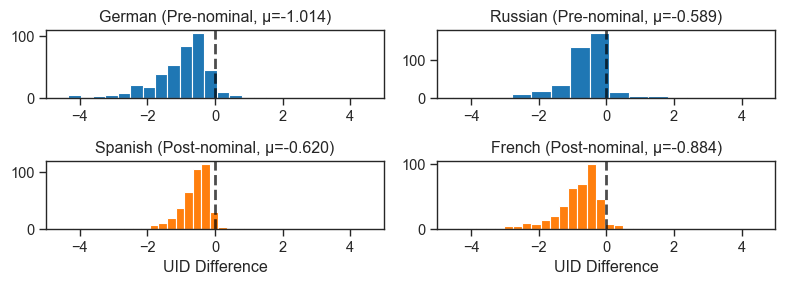

In [59]:
# Create 4 subplots for each language
fig, axes = plt.subplots(2, 2, figsize=(8, 3))
axes = axes.flatten()

# Define colors by adjective position
colors = {
    'de': '#1f77b4',  # Pre-nominal (German)
    'ru': '#1f77b4',  # Pre-nominal (Russian)
    'es': '#ff7f0e',  # Post-nominal (Spanish)
    'fr': '#ff7f0e',  # Post-nominal (French)
}

position_labels = {
    'de': 'Pre-nominal',
    'ru': 'Pre-nominal',
    'es': 'Post-nominal',
    'fr': 'Post-nominal',
}

for idx, lang_code in enumerate(['de', 'ru', 'es', 'fr']):
    if lang_code in results:
        diffs = results[lang_code]['diffs']
        label = f"{languages[lang_code]} ({position_labels[lang_code]}, μ={results[lang_code]['mean']:.3f})"
        # axes[idx].hist(diffs, bins=20, alpha=1, color=colors[lang_code])
        sns.histplot(diffs, ax=axes[idx], 
                     color=colors[lang_code],
                     alpha=1,
                     bins=20)
        axes[idx].axvline(x=0, color='black', linestyle='--', linewidth=2, alpha=0.7)
        # if top layer, do not label x:
        if lang_code not in ['de', 'ru']:
            axes[idx].set_xlabel('UID Difference')
        else:
            axes[idx].set_xlabel('')
        axes[idx].set_ylabel('')
        axes[idx].set_title(label)
        axes[idx].set_xlim(-5, 5)

plt.tight_layout()
plt.savefig('figures/Figure1.pdf', dpi=300)
plt.show()

In [47]:
from scipy import stats

# Summary statistics table
print("=" * 70)
print(f"{'Language':<15} {'N Pairs':<10} {'Mean Diff':<15} {'Std Dev':<15} {'p-value':<15}")
print("=" * 70)

for lang_code in ['de', 'ru', 'es', 'fr',]:
    if lang_code in results:
        name = languages[lang_code]
        n = len(results[lang_code]['diffs'])
        mean = results[lang_code]['mean']
        std = results[lang_code]['std']
        # One-sample t-test: H0: mean >= 0, H1: mean < 0
        t_stat, p_value = stats.ttest_1samp(results[lang_code]['diffs'], 0)
        p_value_one_sided = p_value / 2 if t_stat < 0 else 1 - p_value / 2
        # Round to power of 10
        if p_value_one_sided > 0:
            exponent = int(np.floor(np.log10(p_value_one_sided)))
            p_display = f"10^{exponent}"
        else:
            p_display = "0"
        print(f"{name:<15} {n:<10} {mean:>10.4f}   {std:>10.4f}      {p_display:>10}")

print("=" * 70)

Language        N Pairs    Mean Diff       Std Dev         p-value        
German          1417          -0.4268       0.5605         10^-143
Russian         1417          -0.4409       0.5437         10^-158
Spanish         1417          -0.2519       0.4431          10^-88
French          1417          -0.2687       0.4779          10^-87


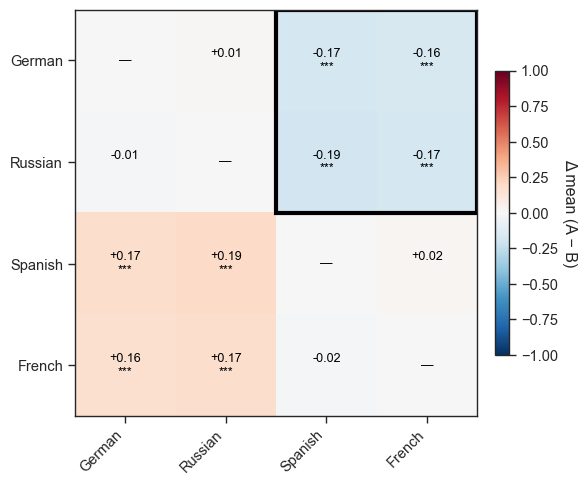

In [48]:
# All-vs-all language comparison
langs = ['de', 'ru', 'es', 'fr']

comp = np.zeros((len(langs), len(langs)))
pval = np.zeros((len(langs), len(langs)))

for i, a in enumerate(langs):
    for j, b in enumerate(langs):
        comp[i, j] = results[a]['mean'] - results[b]['mean']
        if i != j:
            _, pval[i, j] = stats.mannwhitneyu(
                results[a]['diffs'], results[b]['diffs'],
                # alternative='less'
            )
        else:
            pval[i, j] = 1.0  # diagonal

def stars(p):
    return "***" if p < 1e-3 else "**" if p < 1e-2 else "*" if p < 5e-2 else ""

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(comp, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)

ax.set_xticks(range(len(langs)))
ax.set_yticks(range(len(langs)))
ax.set_xticklabels([languages[l] for l in langs], rotation=45, ha='right')
ax.set_yticklabels([languages[l] for l in langs])
ax.set_xlabel(None)
ax.set_ylabel(None)

for i in range(len(langs)):
    for j in range(len(langs)):
        if i == j:
            txt = "—"
        else:
            txt = f"{comp[i,j]:+.2f}\n{stars(pval[i,j])}"
        ax.text(j, i, txt,
                ha="center", va="center",
                color=("white" if abs(comp[i,j]) > 0.5 else "black"),
                fontsize=9)

# Draw thick black rectangle around top-right quadrant (pre-nominal vs post-nominal)
# Top-right quadrant: rows 0-1 (de, ru) vs columns 2-3 (es, fr)
from matplotlib.patches import Rectangle
rect = Rectangle((1.5, -0.5), 2, 2, linewidth=3, edgecolor='black', facecolor='none')
ax.add_patch(rect)

cbar = fig.colorbar(im, ax=ax, 
                    fraction=0.046, 
                    pad=0.04, shrink=0.7)
cbar.set_label("Δ mean (A − B)", rotation=270, labelpad=14)

# ax.set_title("Pairwise Language Comparison\n(row − column)")
plt.tight_layout()
plt.show()

### 2.0. Adding adjectives. 

In [ ]:
with open('sentence_pairs_color_adj_added.pkl', 'rb') as f:
    data_add = pickle.load(f)

In [55]:
# Compute UID differences for all languages
results = {}

for lang_code, data in data_add.items():
    # Limit data if in test mode
    data_to_process = data[:MAX_PAIRS_TEST] if TEST_MODE else data
    
    print(f"\nProcessing {languages[lang_code]} ({lang_code})...")
    print(f"  Processing {len(data_to_process)} of {len(data)} pairs")
    diffs = []
    
    for pair in tqdm(data_to_process, desc=f"{lang_code}"):
        # Tokenize both sentences
        inputs_with_adj = tokenizer(pair[1], return_tensors="pt")
        inputs_without_adj = tokenizer(pair[0], return_tensors="pt")
        
        # Compute UID⁻¹ for both
        uid_with_adj = compute_uid_inverse(model, inputs_with_adj["input_ids"], K)
        uid_without_adj = compute_uid_inverse(model, inputs_without_adj["input_ids"], K)
        
        # Difference: with_adj - without_adj
        diff = uid_with_adj - uid_without_adj
        diffs.append(diff)
    
    results[lang_code] = {
        'diffs': diffs,
        'mean': np.mean(diffs),
        'std': np.std(diffs),
        'pairs': data_to_process
    }
    
    print(f"  Mean difference: {results[lang_code]['mean']:.3f} ± {results[lang_code]['std']:.3f}")

print("\n✓ All languages processed!")


Processing German (de)...
  Processing 400 of 400 pairs


de: 100%|██████████| 400/400 [05:19<00:00,  1.25it/s]


  Mean difference: -1.014 ± 0.891

Processing Spanish (es)...
  Processing 400 of 400 pairs


es: 100%|██████████| 400/400 [05:20<00:00,  1.25it/s]


  Mean difference: -0.620 ± 0.507

Processing French (fr)...
  Processing 400 of 400 pairs


fr: 100%|██████████| 400/400 [05:05<00:00,  1.31it/s]


  Mean difference: -0.884 ± 0.760

Processing Russian (ru)...
  Processing 400 of 400 pairs


ru: 100%|██████████| 400/400 [05:41<00:00,  1.17it/s]

  Mean difference: -0.589 ± 0.829

✓ All languages processed!


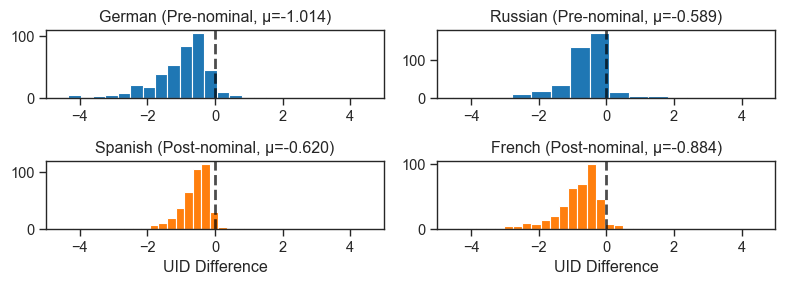

In [60]:
# Create 4 subplots for each language
fig, axes = plt.subplots(2, 2, figsize=(8, 3))
axes = axes.flatten()

# Define colors by adjective position
colors = {
    'de': '#1f77b4',  # Pre-nominal (German)
    'ru': '#1f77b4',  # Pre-nominal (Russian)
    'es': '#ff7f0e',  # Post-nominal (Spanish)
    'fr': '#ff7f0e',  # Post-nominal (French)
}

position_labels = {
    'de': 'Pre-nominal',
    'ru': 'Pre-nominal',
    'es': 'Post-nominal',
    'fr': 'Post-nominal',
}

for idx, lang_code in enumerate(['de', 'ru', 'es', 'fr']):
    if lang_code in results:
        diffs = results[lang_code]['diffs']
        label = f"{languages[lang_code]} ({position_labels[lang_code]}, μ={results[lang_code]['mean']:.3f})"
        # axes[idx].hist(diffs, bins=20, alpha=1, color=colors[lang_code])
        sns.histplot(diffs, ax=axes[idx], 
                     color=colors[lang_code],
                     alpha=1,
                     bins=20)
        axes[idx].axvline(x=0, color='black', linestyle='--', linewidth=2, alpha=0.7)
        # if top layer, do not label x:
        if lang_code not in ['de', 'ru']:
            axes[idx].set_xlabel('UID Difference')
        else:
            axes[idx].set_xlabel('')
        axes[idx].set_ylabel('')
        axes[idx].set_title(label)
        axes[idx].set_xlim(-5, 5)

plt.tight_layout()
plt.savefig('figures/Figure2.pdf', dpi=300)
plt.show()

In [58]:
# print examples of highest and lowest differences for each language
for lang_code in ['de', 'ru', 'es', 'fr']:
    if lang_code not in results:
        continue
    diffs = np.array(results[lang_code]['diffs'])
    pairs = results[lang_code]['pairs']
    if len(diffs) == 0:
        continue

    sorted_idx = np.argsort(diffs)
    n = min(3, len(diffs))

    print(f"\n{languages[lang_code]} ({position_labels[lang_code]}):")
    print("Top {} pairs with highest positive difference:".format(n))
    for idx in sorted_idx[-n:][::-1]:
        print(f" Diff: {diffs[idx]:.3f} | With adj: {pairs[idx][1]} | Without adj: {pairs[idx][0]}")

    print("Top {} pairs with highest negative difference:".format(n))
    for idx in sorted_idx[:n]:
        print(f" Diff: {diffs[idx]:.3f} | With adj: {pairs[idx][1]} | Without adj: {pairs[idx][0]}")


German (Pre-nominal):
Top 3 pairs with highest positive difference:
 Diff: 1.517 | With adj: schwarze Szene 8. | Without adj: Szene 8.
 Diff: 1.127 | With adj: weiße Band 67. | Without adj: Band 67.
 Diff: 1.032 | With adj: Das Wappen zeigt einen aufrechten schwarzen Hirsch . | Without adj: Das Wappen zeigt einen aufrechten Hirsch .
Top 3 pairs with highest negative difference:
 Diff: -5.803 | With adj: rotes Ende des 19. | Without adj: Ende des 19.
 Diff: -5.117 | With adj: rotes Ende des 15. | Without adj: Ende des 15.
 Diff: -4.338 | With adj: Nach der weißen Mitte des 14. | Without adj: Nach der Mitte des 14.

Russian (Pre-nominal):
Top 3 pairs with highest positive difference:
 Diff: 6.430 | With adj: белый Альбом . | Without adj: Альбом .
 Diff: 2.255 | With adj: на зеленый острове построили замок . | Without adj: на острове построили замок .
 Diff: 1.770 | With adj: PolII промоторный регион белый человека . | Without adj: PolII промоторный регион человека .
Top 3 pairs with hig